<a href="https://colab.research.google.com/github/NandaSmith/NandaSmith/blob/main/COMP0087_Transformer_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# (run)

In [ ]:
!pip install tokenizers
!pip install transformers
!pip install datasets

In [ ]:
import pandas as pd
import numpy as np
import re
import tokenizers
import transformers

from datasets import load_dataset, concatenate_datasets

from google.colab import drive
import logging
import time

import matplotlib.pyplot as plt
import tensorflow as tf


from sklearn.model_selection import train_test_split

In [ ]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
train = load_dataset('json', data_files ='gdrive/MyDrive/Data_fix/conala_combined_train-substituted.json')
test = load_dataset('json', data_files = 'gdrive/MyDrive/Data_fix/conala-test-substituted.json')
val = load_dataset('json', data_files = 'gdrive/MyDrive/Data_fix/conala_combined_val-substituted.json')
train = train['train']
test = test['train']
val = val['train']

In [ ]:
# for substituted
val = val.rename_column('intent', 'old_intent')
val = val.rename_column('snippet', 'old_snippet')
val = val.rename_column('my_intent', 'intent')
val = val.rename_column('my_snippet', 'snippet')
val

In [ ]:
# for substituted
train = train.rename_column('intent', 'old_intent')
train = train.rename_column('snippet', 'old_snippet')
train = train.rename_column('my_intent', 'intent')
train = train.rename_column('my_snippet', 'snippet')
train

In [ ]:
# For non-substituted
none_rewritten = train.filter(lambda sample: sample['rewritten_intent'] is None)
rewritten = train.filter(lambda sample: sample['rewritten_intent'] is not None)
none_rewritten = none_rewritten.remove_columns(['rewritten_intent', 'question_id'])
rewritten = rewritten.remove_columns(['intent']).rename_column('rewritten_intent', 'intent')
train = concatenate_datasets([rewritten, none_rewritten])
none_rewritten

In [ ]:
# For Both
train = train.filter(lambda sample: len(sample['snippet']) > 1)

Filter:   0%|          | 0/16788 [00:00<?, ? examples/s]

# Transformer using Keras (run)

In [ ]:
X_train, y_train = train["intent"], train["snippet"]
X_test, y_test = val["intent"], val["snippet"]

# CODEBert tokenizer (run)

In [ ]:
from transformers import AutoTokenizer, AutoModel
input_tokenizer = AutoTokenizer.from_pretrained("microsoft/codebert-base")
output_tokenizer = AutoTokenizer.from_pretrained("microsoft/codebert-base")

In [ ]:
#new method
MAX_TOKENS=128
def prepare_batch_input_intent(intent, snippet):
  intent = tf.convert_to_tensor(input_tokenizer.encode(intent), dtype = tf.int32)
  intent = intent[:(MAX_TOKENS)]
  return intent

def prepare_batch_snippet(intent, snippet):
  snippet = tf.convert_to_tensor(output_tokenizer.encode(snippet), dtype = tf.int32) # Output is ragged.
  snippet = snippet[:MAX_TOKENS+1]    # Trim to MAX_TOKENS.
  #snippet_inputs = snippet[:-1] # trim end token
  return snippet

def prepare_dataset(X, y):
  data = np.transpose(np.array([X, y]))
  input_intent = [prepare_batch_input_intent(x,y) for x, y in data]
  snippet = [prepare_batch_snippet(x,y) for x, y in data]
  input_snippet = [snip[:-1] for snip in snippet]
  label = [snip[1:] for snip in snippet]
  input_intent = tf.ragged.stack(input_intent)#.to_tensor()
  input_snippet = tf.ragged.stack(input_snippet)#.to_tensor()
  label = tf.ragged.stack(label)#.to_tensor()

  out = tf.data.Dataset.from_tensor_slices(((input_intent, input_snippet), label))
  return(out)
def pad_batch(input, snippet):
  x, y = input
  return (x.to_tensor(1), y.to_tensor(1)), snippet.to_tensor(1)
def prepare_batch(ds):
  return(ds.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).map(pad_batch, tf.data.AUTOTUNE))

In [ ]:
BUFFER_SIZE = 20000
BATCH_SIZE = 64
ds_train = prepare_dataset(X_train, y_train)
train_batch = prepare_batch(ds_train)

In [ ]:
ds_test = prepare_dataset(X_test, y_test)
test_batch = prepare_batch(ds_test)

# Normal (run)

In [ ]:
for (input, snippet), snippet_label in train_batch.take(1):
  break
print(input)
print(input.shape)
print(snippet.shape)
print(snippet_label.shape)
print(snippet)
print(snippet_label)

tf.Tensor(
[[    0  6179     7 ...     1     1     1]
 [    0 26615   114 ...     1     1     1]
 [    0 48659   111 ...     1     1     1]
 ...
 [    0  6179   109 ...     1     1     1]
 [    0  6179   109 ... 31886   116     2]
 [    0 48659    35 ...     1     1     1]], shape=(64, 21), dtype=int32)
(64, 21)
(64, 47)
(64, 47)
tf.Tensor(
[[    0 43103     4 ...     1     1     1]
 [    0 10398     4 ...     1     1     1]
 [    0 18581  1640 ...     1     1     1]
 ...
 [    0 30921   646 ...     1     1     1]
 [    0 48759  2652 ...     1     1     1]
 [    0  6460 44156 ...     1     1     1]], shape=(64, 47), dtype=int32)
tf.Tensor(
[[43103     4 47717 ...     1     1     1]
 [10398     4  2089 ...     1     1     1]
 [18581  1640 10806 ...     1     1     1]
 ...
 [30921   646 10806 ...     1     1     1]
 [48759  2652 26960 ...     1     1     1]
 [ 6460 44156  1640 ...     1     1     1]], shape=(64, 47), dtype=int32)


In [ ]:
def positional_encoding(length, depth):
  depth = depth/2

  positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
  depths = np.arange(depth)[np.newaxis, :]/depth   # (1, depth)
  
  angle_rates = 1 / (10000**depths)         # (1, depth)
  angle_rads = positions * angle_rates      # (pos, depth)

  pos_encoding = np.concatenate(
      [np.sin(angle_rads), np.cos(angle_rads)],
      axis=-1) 

  return tf.cast(pos_encoding, dtype=tf.float32)

# BERT (run)

In [ ]:
vocab_size = len(input_tokenizer.get_vocab())

In [ ]:
# BERT
class PositionalEmbedding(tf.keras.layers.Layer):
  def __init__(self, vocab_size, d_model):
    super().__init__()
    self.d_model = d_model
    self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero=False) 
    self.pos_encoding = positional_encoding(length=2048, depth=d_model)
    self.mask_zero = False

  def compute_mask(self, inputs, mask=None, *args, **kwargs):
    if not self.mask_zero:
        return tf.not_equal(inputs, 1)
    return tf.not_equal(inputs, 0)

  def call(self, x):
    length = tf.shape(x)[1]
    x = self.embedding(x)
    # This factor sets the relative scale of the embedding and positonal_encoding.
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x = x + self.pos_encoding[tf.newaxis, :length, :]
    return x


In [ ]:
print(input)

tf.Tensor(
[[    0  6179     7 ...     1     1     1]
 [    0 26615   114 ...     1     1     1]
 [    0 48659   111 ...     1     1     1]
 ...
 [    0  6179   109 ...     1     1     1]
 [    0  6179   109 ... 31886   116     2]
 [    0 48659    35 ...     1     1     1]], shape=(64, 21), dtype=int32)


In [ ]:
# For Bert
embed_input = PositionalEmbedding(vocab_size=len(input_tokenizer.get_vocab()), d_model=512)
embed_snippet = PositionalEmbedding(vocab_size=len(output_tokenizer.get_vocab()), d_model=512)

input_emb = embed_input(input)
snippet_emb = embed_snippet(snippet)
snippet_emb._keras_mask

<tf.Tensor: shape=(64, 47), dtype=bool, numpy=
array([[ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       ...,
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False]])>

In [ ]:
# BERT
def masked_loss(label, pred):
  mask = label != 1 
  loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')
  loss = loss_object(label, pred)

  mask = tf.cast(mask, dtype=loss.dtype)
  loss *= mask

  loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
  return loss


def masked_accuracy(label, pred):
  pred = tf.argmax(pred, axis=2)
  label = tf.cast(label, pred.dtype)
  match = label == pred

  mask = label != 1

  match = match & mask

  match = tf.cast(match, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)
  return tf.reduce_sum(match)/tf.reduce_sum(mask)

# Everything (run)

In [ ]:
class BaseAttention(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    self.layernorm = tf.keras.layers.LayerNormalization()
    self.add = tf.keras.layers.Add()

In [ ]:
class CrossAttention(BaseAttention):
  def call(self, x, context):
    attn_output, attn_scores = self.mha(
        query=x,
        key=context,
        value=context,
        return_attention_scores=True)
   
    # Cache the attention scores for plotting later.
    self.last_attn_scores = attn_scores

    x = self.add([x, attn_output])
    x = self.layernorm(x)

    return x

In [ ]:
#sample_ca = CrossAttention(num_heads=2, key_dim=512)
#
#print(input_emb.shape)
#print(snippet_emb.shape)
#print(sample_ca(snippet_emb, input_emb).shape)

In [ ]:
class GlobalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(
        query=x,
        value=x,
        key=x)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

In [ ]:
class CausalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(
        query=x,
        value=x,
        key=x,
        use_causal_mask = True)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

In [ ]:
class FeedForward(tf.keras.layers.Layer):
  def __init__(self, d_model, dff, dropout_rate=0.1):
    super().__init__()
    self.seq = tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),
      tf.keras.layers.Dense(d_model),
      tf.keras.layers.Dropout(dropout_rate)
    ])
    self.add = tf.keras.layers.Add()
    self.layer_norm = tf.keras.layers.LayerNormalization()

  def call(self, x):
    x = self.add([x, self.seq(x)])
    x = self.layer_norm(x) 
    return x

In [ ]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self,*, d_model, num_heads, dff, dropout_rate=0.1):
    super().__init__()

    self.self_attention = GlobalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.ffn = FeedForward(d_model, dff)

  def call(self, x):
    x = self.self_attention(x)
    x = self.ffn(x)
    return x

In [ ]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads,
               dff, vocab_size, dropout_rate=0.1):
    super().__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.pos_embedding = PositionalEmbedding(
        vocab_size=vocab_size, d_model=d_model)

    self.enc_layers = [
        EncoderLayer(d_model=d_model,
                     num_heads=num_heads,
                     dff=dff,
                     dropout_rate=dropout_rate)
        for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(dropout_rate)

  def call(self, x):
    # `x` is token-IDs shape: (batch, seq_len)
    x = self.pos_embedding(x)  # Shape `(batch_size, seq_len, d_model)`.
    
    # Add dropout.
    x = self.dropout(x)

    for i in range(self.num_layers):
      x = self.enc_layers[i](x)

    return x  # Shape `(batch_size, seq_len, d_model)`.

In [ ]:
# Instantiate the encoder.
sample_encoder = Encoder(num_layers=4,
                         d_model=512,
                         num_heads=8,
                         dff=2048,
                         vocab_size=vocab_size)

sample_encoder_output = sample_encoder(input, training=False)

# Print the shape.
print(input.shape)
print(sample_encoder_output.shape)  # Shape `(batch_size, input_seq_len, d_model)`.

(64, 21)
(64, 21, 512)


In [ ]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self,
               *,
               d_model,
               num_heads,
               dff,
               dropout_rate=0.1):
    super(DecoderLayer, self).__init__()

    self.causal_self_attention = CausalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)
    
    self.cross_attention = CrossAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.ffn = FeedForward(d_model, dff)

  def call(self, x, context):
    x = self.causal_self_attention(x=x)
    x = self.cross_attention(x=x, context=context)

    # Cache the last attention scores for plotting later
    self.last_attn_scores = self.cross_attention.last_attn_scores

    x = self.ffn(x)  # Shape `(batch_size, seq_len, d_model)`.
    return x

In [ ]:
print(snippet_emb.shape)
print(input_emb.shape)

(64, 47, 512)
(64, 21, 512)


In [ ]:
sample_decoder_layer = DecoderLayer(d_model=512, num_heads=8, dff=2048)

sample_decoder_layer_output = sample_decoder_layer(
    x=snippet_emb, context=input_emb)

print(snippet_emb.shape)
print(input_emb.shape)
print(sample_decoder_layer_output.shape)  # `(batch_size, seq_len, d_model)`

(64, 47, 512)
(64, 21, 512)
(64, 47, 512)


In [ ]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads, dff, vocab_size,
               dropout_rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.pos_embedding = PositionalEmbedding(vocab_size=vocab_size,
                                             d_model=d_model)
    self.dropout = tf.keras.layers.Dropout(dropout_rate)
    self.dec_layers = [
        DecoderLayer(d_model=d_model, num_heads=num_heads,
                     dff=dff, dropout_rate=dropout_rate)
        for _ in range(num_layers)]

    self.last_attn_scores = None

  def call(self, x, context):
    # `x` is token-IDs shape (batch, target_seq_len)
    x = self.pos_embedding(x)  # (batch_size, target_seq_len, d_model)

    x = self.dropout(x)

    for i in range(self.num_layers):
      x  = self.dec_layers[i](x, context)

    self.last_attn_scores = self.dec_layers[-1].last_attn_scores

    # The shape of x is (batch_size, target_seq_len, d_model).
    return x

In [ ]:
# Instantiate the decoder.
sample_decoder = Decoder(num_layers=4,
                         d_model=512,
                         num_heads=8,
                         dff=2048,
                         vocab_size=vocab_size)

output = sample_decoder(
    x=snippet,
    context=input_emb)

# Print the shapes.
print(snippet.shape)
print(input_emb.shape)
print(output.shape)

(64, 47)
(64, 21, 512)
(64, 47, 512)


In [ ]:
class Transformer(tf.keras.Model):
  def __init__(self, *, num_layers, d_model, num_heads, dff,
               input_vocab_size, target_vocab_size, dropout_rate=0.1):
    super().__init__()
    self.encoder = Encoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           vocab_size=input_vocab_size,
                           dropout_rate=dropout_rate)

    self.decoder = Decoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           vocab_size=target_vocab_size,
                           dropout_rate=dropout_rate)

    self.final_layer = tf.keras.layers.Dense(target_vocab_size)

  def call(self, inputs):
    # To use a Keras model with `.fit` you must pass all your inputs in the
    # first argument.
    context, x  = inputs

    context = self.encoder(context)  # (batch_size, context_len, d_model)

    x = self.decoder(x, context)  # (batch_size, target_len, d_model)

    # Final linear layer output.
    logits = self.final_layer(x)  # (batch_size, target_len, target_vocab_size)

    try:
      # Drop the keras mask, so it doesn't scale the losses/metrics.
      # b/250038731
      del logits._keras_mask
    except AttributeError:
      pass

    # Return the final output and the attention weights.
    return logits

In [ ]:
# Hyper Parameters
num_layers = 4
d_model = 128
dff = 512
num_heads = 8
dropout_rate = 0.1

In [ ]:
transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=vocab_size,
    target_vocab_size=vocab_size,
    dropout_rate=dropout_rate)

In [ ]:
output = transformer((snippet, input))

print(snippet.shape)
print(input.shape)
print(output.shape)

(64, 47)
(64, 21)
(64, 21, 50265)


In [ ]:
transformer.summary()

Model: "transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_1 (Encoder)         multiple                  9072768   
                                                                 
 decoder_1 (Decoder)         multiple                  11183744  
                                                                 
 dense_34 (Dense)            multiple                  6484185   
                                                                 
Total params: 26,740,697
Trainable params: 26,740,697
Non-trainable params: 0
_________________________________________________________________


In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super().__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    step = tf.cast(step, dtype=tf.float32)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

  def get_config(self):
    config = {
    'd_model': self.d_model,
    'warmup_steps': self.warmup_steps

     }
    return config

    

In [ ]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

Text(0.5, 0, 'Train Step')

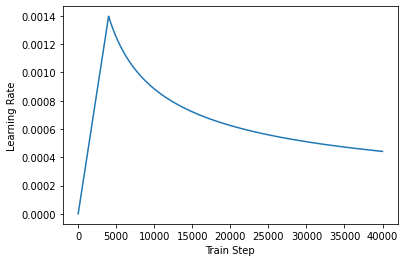

In [ ]:
plt.plot(learning_rate(tf.range(40000, dtype=tf.float32)))
plt.ylabel('Learning Rate')
plt.xlabel('Train Step')

In [ ]:
transformer.compile(
    loss=masked_loss,
    optimizer=optimizer,
    metrics=[masked_accuracy])

# Concentrate (run)

In [ ]:
transformer.fit(train_batch,
                epochs=30,
                validation_data=test_batch)

Epoch 1/30
263/263 [==============================] - 2241s 8s/step - loss: 9.9020 - masked_accuracy: 0.0649 - val_loss: 8.1829 - val_masked_accuracy: 0.1172
Epoch 2/30
177/263 [===================>..........] - ETA: 10:57 - loss: 6.7339 - masked_accuracy: 0.1516

In [ ]:
# Save the entire model as a SavedModel.
transformer.save('gdrive/MyDrive/substituted_e30_data_fix', include_optimizer= False)

In [ ]:
transformer.save_weights('gdrive/MyDrive/substituted_e30_data_fix/weights_data')

In [ ]:
transformer.load_weights("gdrive/MyDrive/combined_e18")

# Run the Inference Part

In [ ]:
start_id = input_tokenizer.encode('</s>')
start_id

[0, 2, 2]

In [ ]:
# BERT
class Translator(tf.Module):
  def __init__(self, input_tokenizer, output_tokenizer, transformer):
    self.input_tokenizer = input_tokenizer
    self.output_tokenizer = output_tokenizer
    self.transformer = transformer

  def __call__(self, sentence, max_length=MAX_TOKENS):
    # The input sentence is Portuguese, hence adding the `[START]` and `[END]` tokens.
    #assert isinstance(sentence, tf.Tensor)
    #if len(sentence.shape) == 0:
    #  sentence = sentence[tf.newaxis]

    sentence = tf.convert_to_tensor([self.input_tokenizer.encode(sentence)])

    encoder_input = sentence

    # As the output language is English, initialize the output with the
    # English `[START]` token.
    start = self.output_tokenizer.encode('')[0]
    end = self.output_tokenizer.encode('')[1]
    start = tf.convert_to_tensor([start], dtype = tf.int64)
    end = tf.convert_to_tensor([end], dtype = tf.int64)

    # `tf.TensorArray` is required here (instead of a Python list), so that the
    # dynamic-loop can be traced by `tf.function`.
    output_array = tf.TensorArray(dtype=tf.int64, size=0, dynamic_size=True)
    output_array = output_array.write(0, start)

    for i in tf.range(max_length):
      output = tf.transpose(output_array.stack())
      predictions = self.transformer([encoder_input, output], training=False)

      # Select the last token from the `seq_len` dimension.
      predictions = predictions[:, -1:, :]  # Shape `(batch_size, 1, vocab_size)`.

      predicted_id = tf.argmax(predictions, axis=-1)

      # Concatenate the `predicted_id` to the output which is given to the
      # decoder as its input.
      output_array = output_array.write(i+1, predicted_id[0])

      if predicted_id == end:
        break

    output = tf.transpose(output_array.stack())
    # The output shape is `(1, tokens)`.
    text = output_tokenizer.decode(output.numpy()[0])#[0]  # Shape: `()`.
    tokens = output_tokenizer.convert_ids_to_tokens(output.numpy()[0])

    # `tf.function` prevents us from using the attention_weights that were
    # calculated on the last iteration of the loop.
    # So, recalculate them outside the loop.
    self.transformer([encoder_input, output[:,:-1]], training=False)
    attention_weights = self.transformer.decoder.last_attn_scores

    return text, tokens, attention_weights

In [ ]:
translator = Translator(input_tokenizer, output_tokenizer, transformer)

In [ ]:
def print_translation(sentence, tokens, ground_truth):
  print(f'{"Input:":15s}: {sentence}')
  print(f'{"Prediction":15s}: {tokens}')
  print(f'{"Ground truth":15s}: {ground_truth}')

In [ ]:
sentence = test['intent'][0]
ground_truth = test['snippet'][0]
translated_text, translated_tokens, attention_weights = translator(sentence) #tf.constant(sentence)
print_translation(sentence, translated_text, ground_truth)

Input:         : How can I send a signal from a python program?
Prediction     : <s>url('^.$', include('myapp.urls'))</s>
Ground truth   : os.kill(os.getpid(), signal.SIGUSR1)


In [ ]:
sentence = test['intent'][1]
ground_truth = test['snippet'][1]

translated_text, translated_tokens, attention_weights = translator(sentence)
print_translation(sentence, translated_text, ground_truth)

Input:         : Decode Hex String in Python 3
Prediction     : <s>print('{0:04X}'.format(var1, var2))</s>
Ground truth   : bytes.fromhex('4a4b4c').decode('utf-8')


In [ ]:
sentence = test['intent'][2]
ground_truth = test['snippet'][2]

translated_text, translated_tokens, attention_weights = translator(sentence)
print_translation(sentence, translated_text, ground_truth)

Input:         : check if all elements in a list are identical
Prediction     : <s>print(all(var1 == var2 for var1, var2 in group_(var3))</s>
Ground truth   : all(x == myList[0] for x in myList)


In [ ]:
sentence = test['intent'][3]
ground_truth = test['snippet'][3]

translated_text, translated_tokens, attention_weights = translator(sentence)
print_translation(sentence, translated_text, ground_truth)

Input:         : Format string dynamically
Prediction     : <s>"""foo {0} {1}""".format(**format(var1, var2))</s>
Ground truth   : print('%*s : %*s' % (20, 'Python', 20, 'Very Good'))


In [ ]:
sentence = test['intent'][4]
ground_truth = test['snippet'][4]

translated_text, translated_tokens, attention_weights = translator(sentence)
print_translation(sentence, translated_text, ground_truth)

Input:         : How to convert a string from CP-1251 to UTF-8?
Prediction     : <s>s.encode('utf8')</s>
Ground truth   : d.decode('cp1251').encode('utf8')


In [ ]:
sentence = test['intent'][5]
ground_truth = test['snippet'][5]

translated_text, translated_tokens, attention_weights = translator(sentence)
print_translation(sentence, translated_text, ground_truth)

Input:         : How I can get rid of None values in dictionary?
Prediction     : <s>{'count': num1}</s>
Ground truth   : res = {k: v for k, v in list(kwargs.items()) if v is not None}


In [ ]:
sentence = test['intent'][6]
ground_truth = test['snippet'][6]

translated_text, translated_tokens, attention_weights = translator(sentence)
print_translation(sentence, translated_text, ground_truth)

Input:         : How I can get rid of None values in dictionary?
Prediction     : <s>{'count': num1}</s>
Ground truth   : res = dict((k, v) for k, v in kwargs.items() if v is not None)


In [ ]:
sentence = test['intent'][7]
ground_truth = test['snippet'][7]

translated_text, translated_tokens, attention_weights = translator(sentence)
print_translation(sentence, translated_text, ground_truth)

Input:         : Python: how to get the final output of multiple system commands?
Prediction     : <s>os.path.basename(var1)</s>
Ground truth   : subprocess.check_output('ps -ef | grep something | wc -l', shell=True)


# BLEU Score

In [ ]:
!pip install evaluate

In [ ]:
import evaluate

predictions = []
references = []
temp_ref = []
i = 0
prev_intent = ''
for intent, ground_truth in zip(test['intent'], test['snippet']):
  i += 1
  print(i, intent)
  if intent == prev_intent:
    temp_ref += [ground_truth]
  else:
    if i != 1:
      references += [temp_ref]
    temp_ref = []
    translated_text, translated_tokens, attention_weights = translator(intent)
    temp_ref += [ground_truth]
    predictions += [translated_text[3:-4]] # check
  prev_intent = intent
references += [temp_ref]

1 How can I send a signal from a python program?
2 Decode Hex String in Python 3
3 check if all elements in a list are identical
4 Format string dynamically
5 How to convert a string from CP-1251 to UTF-8?
6 How I can get rid of None values in dictionary?
7 How I can get rid of None values in dictionary?
8 Python: how to get the final output of multiple system commands?
9 splitting and concatenating a string
10 Finding the intersection between two series in Pandas
11 Sending http headers with python
12 Python -Remove Time from Datetime String
13 How do I split a multi-line string into multiple lines?
14 How do I split a multi-line string into multiple lines?
15 How to join mixed list (array) (with integers in it) in Python?
16 Fastest way to get the first object from a queryset in django?
17 How to calculate the sum of all columns of a 2D numpy array (efficiently)
18 Python, how to enable all warnings?
19 Python printing without commas
20 OSError: [WinError 193] %1 is not a valid Win32

In [ ]:
bleu = evaluate.load("bleu")
results = bleu.compute(predictions=predictions, references=references)
print(results)

{'bleu': 0.11294971511792858, 'precisions': [0.38620689655172413, 0.125, 0.07086614173228346, 0.059322033898305086], 'brevity_penalty': 0.9463219749260535, 'length_ratio': 0.9477124183006536, 'translation_length': 145, 'reference_length': 153}


# Attention plots|

In [ ]:
def plot_attention_head(in_tokens, translated_tokens, attention):
  # The model didn't generate `<START>` in the output. Skip it.
  translated_tokens = translated_tokens[1:]

  ax = plt.gca()
  ax.matshow(attention)
  ax.set_xticks(range(len(in_tokens)))
  ax.set_yticks(range(len(translated_tokens)))

  labels = [label for label in in_tokens]
  ax.set_xticklabels(
      labels, rotation=90)

  labels = [label for label in translated_tokens]
  ax.set_yticklabels(labels)

In [ ]:
head = 0
# Shape: `(batch=1, num_heads, seq_len_q, seq_len_k)`.
attention_heads = tf.squeeze(attention_weights, 0)
attention = attention_heads[head]
attention.shape

TensorShape([23, 10])

In [ ]:
in_tokens = sentence
in_tokens = input_tokenizer.encode(in_tokens)
in_tokens = input_tokenizer.convert_ids_to_tokens(in_tokens)
in_tokens

['<s>',
 'S',
 'orting',
 'Ġa',
 'ĠPython',
 'Ġlist',
 'Ġby',
 'Ġtwo',
 'Ġcriteria',
 '</s>']

In [ ]:
translated_tokens

['<s>', '[', '(', 'x', '.', 'items', '()', '</s>']

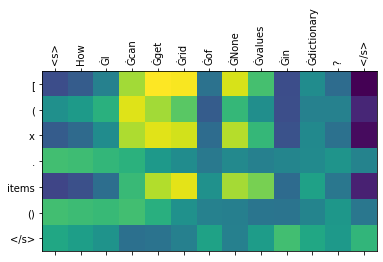

In [ ]:
plot_attention_head(in_tokens, translated_tokens, attention)

In [ ]:
# BERT
def plot_attention_weights(sentence, translated_tokens, attention_heads):
  in_tokens = sentence
  in_tokens = input_tokenizer.encode(in_tokens)
  in_tokens = input_tokenizer.convert_ids_to_tokens(in_tokens)
  in_tokens

  fig = plt.figure(figsize=(16, 8))

  for h, head in enumerate(attention_heads):
    ax = fig.add_subplot(2, 4, h+1)

    plot_attention_head(in_tokens, translated_tokens, head)

    ax.set_xlabel(f'Head {h+1}')

  plt.tight_layout()
  plt.show()

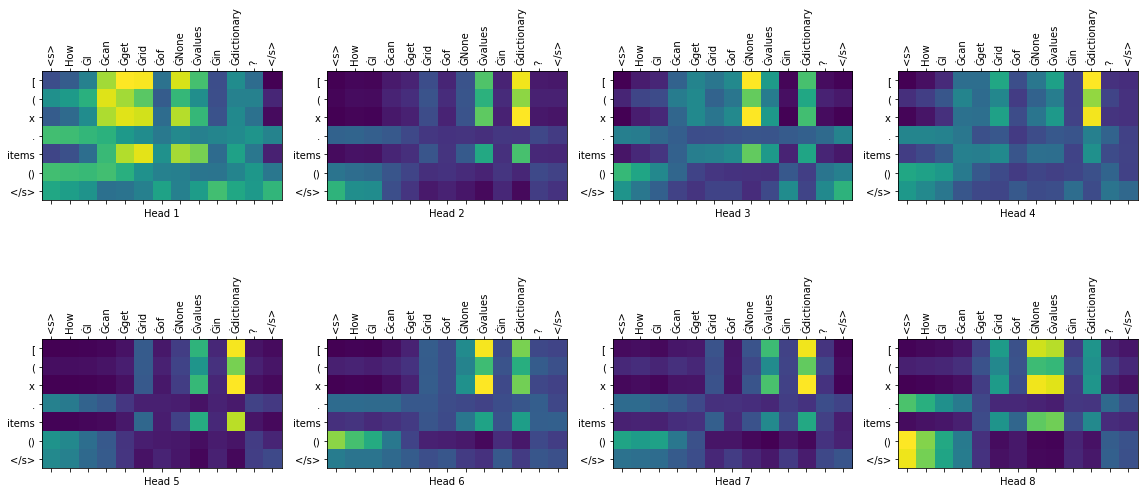

In [ ]:
plot_attention_weights(sentence,
                       translated_tokens,
                       attention_weights[0])

In [ ]:
class ExportTranslator(tf.Module):
  def __init__(self, translator):
    self.translator = translator

  @tf.function(input_signature=[tf.TensorSpec(shape=[], dtype=tf.string)])
  def __call__(self, sentence):
    (result,
     tokens,
     attention_weights) = self.translator(sentence, max_length=MAX_TOKENS)

    return result

In [ ]:
translator = ExportTranslator(translator)